In [ ]:
!pip install r-wrapper

In [1]:
from r_wrapper import diftrans
from r_wrapper import base
from r_wrapper import stats
import pandas as pd
import numpy as np

## 3.2 Understanding the Data

In [2]:
# Beijing_sample = pd.read_csv('Beijing_sample.csv')
# Tianjin_sample = pd.read_csv('Tianjin_sample.csv')

Beijing_sample = base.get("Beijing_sample")
Tianjin_sample = base.get("Tianjin_sample")

In [3]:
Beijing_sample.head()

,id,year,month,ym,city,MSRP,sales,swtprice,color,noticenum,postBeijing,postTianjin,Beijing,Tianjin,Shijiazhuang,policy_dummy
1,416024,2010,1,14610.0,Beijing,139800,9.0,152.90585,灰,TV7161GLD,0.0,0.0,1.0,0.0,0.0,0
2,416025,2010,1,14610.0,Beijing,55900,145.0,152.90585,蓝,QCJ7151A5,0.0,0.0,1.0,0.0,0.0,0
3,416026,2010,1,14610.0,Beijing,207800,21.0,152.90585,黑,TV6460DLXM,0.0,0.0,1.0,0.0,0.0,0
4,416027,2010,1,14610.0,Beijing,105700,0.0,152.90585,黑灰,SDH6470M3,0.0,0.0,1.0,0.0,0.0,0
5,416028,2010,1,14610.0,Beijing,120800,3.0,152.90585,白,BH7165MX,0.0,0.0,1.0,0.0,0.0,0


In [4]:
Tianjin_sample.head()

,id,year,month,ym,city,MSRP,sales,swtprice,color,noticenum,postBeijing,postTianjin,Beijing,Tianjin,Shijiazhuang,policy_dummy
1,1737542,2010,1,14610.0,Tianjin,120800,2.0,121.25181,红,BH7165MX,0.0,0.0,0.0,1.0,0.0,0
2,1737543,2010,1,14610.0,Tianjin,120800,3.0,121.25181,灰,LZ6511AQ3S,0.0,0.0,0.0,1.0,0.0,0
3,1737544,2010,1,14610.0,Tianjin,288000,4.0,121.25181,黄,CAF7204A,0.0,0.0,0.0,1.0,0.0,0
4,1737545,2010,1,14610.0,Tianjin,66800,0.0,121.25181,灰,MR7150B4,0.0,0.0,0.0,1.0,0.0,0
5,1737546,2010,1,14610.0,Tianjin,49800,3.0,121.25181,红,LZW7120K3Q,0.0,0.0,0.0,1.0,0.0,0


## 3.3 Clean Data of Beijing and Tianjin Car Sales

In [5]:
# keep 2010 and 2011 data only
Beijing = Beijing_sample[(Beijing_sample['year']>= 2010) & (Beijing_sample['year'] < 2012)]

In [6]:
# collect unique MSRP values
uniqueMSRP = pd.DataFrame(Beijing.MSRP.unique()).rename(columns={0:'MSRP'})

In [7]:
# aggregate sales at each price for 2010 (pre-lottery)
Beijing10_sales = Beijing[(Beijing['year']== 2010)].groupby('MSRP').aggregate({'sales':[sum]})
Beijing10_sales = Beijing10_sales.unstack().reset_index().rename_axis(None, axis=1)
Beijing10_sales = Beijing10_sales.drop(columns=['level_0', 'level_1']).rename(columns={0:'count'})

In [8]:
# merge the MSRP and sales
Beijing_pre = uniqueMSRP.merge(Beijing10_sales, how='left', on = "MSRP")
Beijing_pre[['count']] = Beijing_pre[['count']].fillna(value=0)
Beijing_pre = Beijing_pre.sort_values('MSRP')

# preview data
Beijing_pre.head()

,MSRP,count
482,20800,0.0
374,29800,47.0
338,32900,3153.0
227,33800,3678.0
388,34800,592.0


## 3.4 Visualize Beijing Car Sales

,MSRP,count
482,20800,23.0
374,29800,0.0
338,32900,1393.0
227,33800,4.0
388,34800,189.0


In [10]:
# uncount
df2 = Beijing_pre.pop('count')
Beijing_distribution_pre = pd.DataFrame(Beijing_pre.values.repeat(df2, axis=0), columns=Beijing_pre.columns)

In [11]:
df3 = Beijing_post.pop('count')
Beijing_distribution_post = pd.DataFrame(Beijing_post.values.repeat(df3, axis=0), columns=Beijing_post.columns)

No handles with labels found to put in legend.


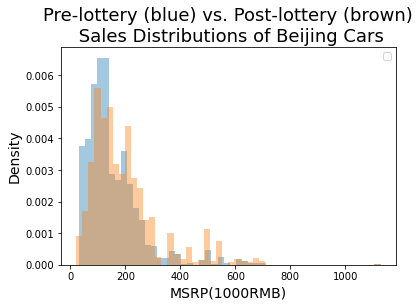

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
for a in [Beijing_distribution_pre, Beijing_distribution_post]:
    sns.distplot(a/1000, ax=ax, kde=False, norm_hist=True)
plt.xlabel("MSRP(1000RMB)", size=14)
plt.ylabel("Density", size=14)
plt.title("Pre-lottery (blue) vs. Post-lottery (brown)\n Sales Distributions of Beijing Cars", size=18)
plt.legend(loc='upper right')
# ax.set_xlim([0, 1200])

## 3.5 Compute Before-and-After Estimator

In [13]:
base.set_seed(0) # for reproducibility
n_observations = 100000
placebo_demonstration = pd.DataFrame({'sample1': np.random.normal(0, 1, n_observations), 'sample2': np.random.normal(0, 1, n_observations)})
placebo_demonstration.head()

,sample1,sample2
0,-0.405173,-0.122613
1,-0.810737,1.257694
2,-0.756124,0.386733
3,0.294862,-0.271587
4,0.476376,-0.501680


Text(0.5, 1.0, 'Two Samples from Standard Normal Distribution')

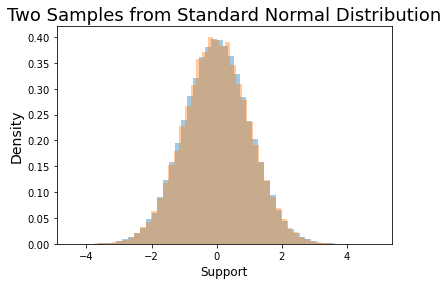

In [14]:
fig, ax = plt.subplots()
ax = sns.distplot(placebo_demonstration['sample1'], ax=ax, kde=False, norm_hist=True)
ax = sns.distplot(placebo_demonstration['sample2'], ax=ax, kde=False, norm_hist=True)
plt.xlabel("Support", size=12)
plt.ylabel("Density", size=14)
plt.title("Two Samples from Standard Normal Distribution", size=18)

In [123]:
# set the seed for reproducibility set.seed(1)
# We will use the `rmultinom` function to construct our placebo.
# Imagine the same number of cars as in 2010. (see `size` argument)
# For each MSRP value, we will decide how many of these imaginary cars will
# be sold at this price. The number of of these imaginary cars to be sold at
# the particular MSRP value will be proportional to the actual number of cars
# sold in the pre-lottery distribution. (see `prob` argument) # We only want one placebo distribution. (see `n` argument) placebo_1 <- data.frame(MSRP = Beijing_pre[‘MSRP’],
base.set_seed(1)
Beijing_pre = uniqueMSRP.merge(Beijing10_sales, how='left', on = "MSRP")
Beijing_pre[['count']] = Beijing_pre[['count']].fillna(value=0)
Beijing_pre = Beijing_pre.sort_values('MSRP')
count =  stats.rmultinom(n = 1, size = sum(Beijing_pre['count']), prob = Beijing_pre['count'])
count2 = count[:,0]
d = {'MSRP': Beijing_pre['MSRP'], 'count' : count2}
placebo_1 = pd.DataFrame(data=d)
print(placebo_1)
print(placebo_1.dtypes)

        MSRP  count
482    20800      0
374    29800     50
338    32900   3136
227    33800   3597
388    34800    539
..       ...    ...
263   703600    350
7     770000    101
314   800400      2
433   998000      6
5    1127800    325

[513 rows x 2 columns]
MSRP     int64
count    int32
dtype: object


        MSRP  count
482    20800      0
374    29800     64
338    32900   3108
227    33800   3647
388    34800    603
..       ...    ...
263   703600    371
7     770000    103
314   800400      3
433   998000      2
5    1127800    305

[513 rows x 2 columns]
MSRP     int64
count    int32
dtype: object


In [125]:
placebo_at_0 = diftrans.diftrans(pre_main = placebo_1, post_main = placebo_2, bandwidth_seq = 0)
placebo_at_0

R[write to console]: Computing Transport Costs...



R[write to console]: The transport cost for the specified bandwidths have been computed.



,bandwidth,main
1,0,0.010787


## 3.6 Compute Differences-in-Transports Estimator

,MSRP,count
448,20800,0.0
464,28800,0.0
358,29800,51.0
494,30900,0.0
327,32900,599.0


,MSRP,count
448,20800,23.0
464,28800,7.0
358,29800,5.0
494,30900,1.0
327,32900,948.0


In [129]:
dit_at_0 = diftrans.diftrans(pre_main = Beijing_pre, post_main = Beijing_post, pre_control = Tianjin_pre, post_control = Tianjin_post, bandwidth_seq = 0, conservative = True)
dit_at_0

R[write to console]: Computing Differences-in-Transports Estimator...

R[write to console]: Note: you are using `conservative = T`.



R[write to console]: The conservative diff-in-transports estimator is 0.0544428953078284 at d = 0



,bandwidth,main,main2d,control,diff,diff2d
1,0,0.353123,0.353123,0.298681,0.054443,0.054443
